In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import warnings


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Suppress SADeprecationWarning
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
print(Base.classes.keys())


['measurement', 'station']


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

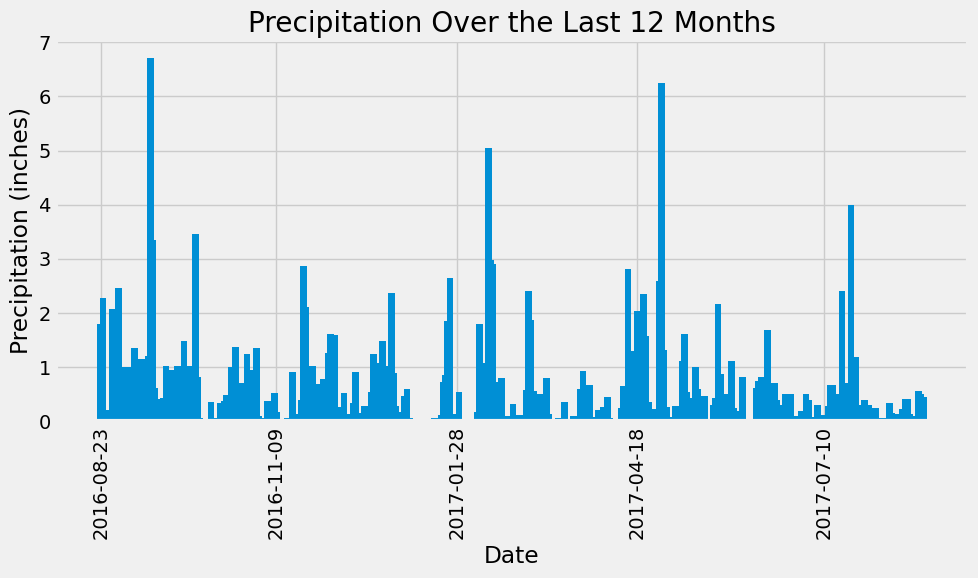

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year before the most recent date in the dataset
last_date = session.query(func.max(Measurement.date)).scalar()
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')

# Reduce the year value by 1
one_year_ago = last_date.replace(year=last_date.year - 1).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores for the last 12 months
results = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= one_year_ago
).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values('Date')
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,6))
plt.bar(df['Date'], df['Precipitation'], width=3)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Over the Last 12 Months')

# Set the specific dates as x-axis tick labels
specific_dates = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
plt.xticks(specific_dates, rotation=90)

plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
summary_statistics

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(func.distinct(Measurement.station))).scalar()
total_stations

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
# List the stations and their counts in descending order.
for station, row_count in active_stations:
    print(f"Station: {station}, Row Count: {row_count}")

Station: USC00519281, Row Count: 2772
Station: USC00519397, Row Count: 2724
Station: USC00513117, Row Count: 2709
Station: USC00519523, Row Count: 2669
Station: USC00516128, Row Count: 2612
Station: USC00514830, Row Count: 2202
Station: USC00511918, Row Count: 1979
Station: USC00517948, Row Count: 1372
Station: USC00518838, Row Count: 511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Define the most active station id
most_active_station = active_stations[0][0]

temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(temperature_stats)


[(54.0, 85.0, 71.66378066378067)]


In [16]:
# Determine the most recent date of measurement for the station 'USC00519281'
most_recent_date = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station).scalar()
most_recent_date

'2017-08-18'

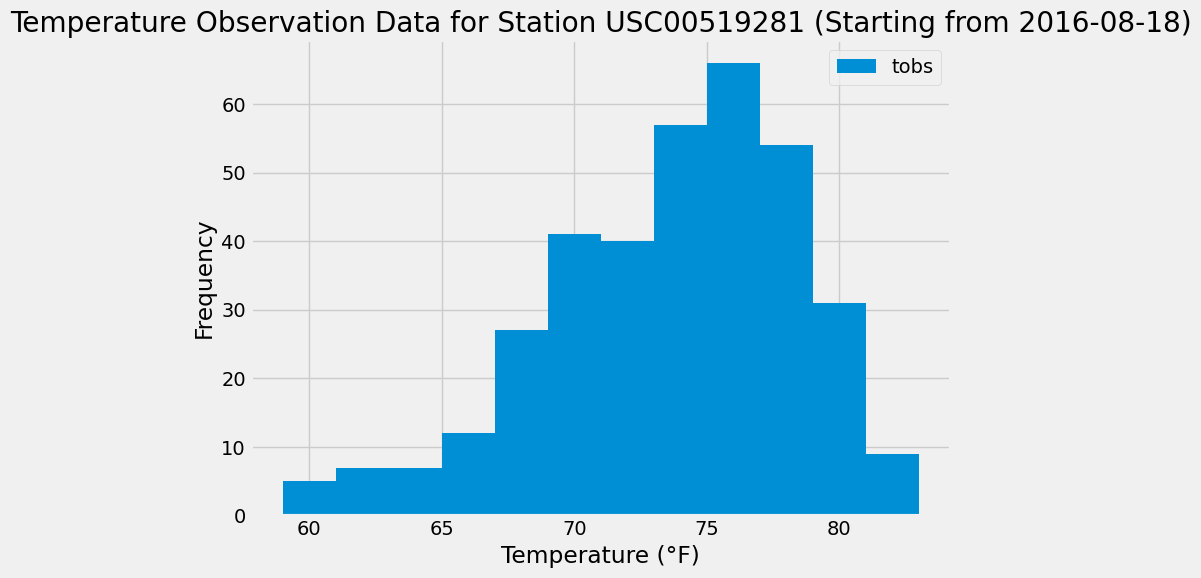

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Query the TOBS data for the previous 12 months for the most active station
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year before the most recent date
one_year_ago = most_recent_date.replace(year=most_recent_date.year - 1)

results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

temperatures = [result[1] for result in results]


plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data for Station USC00519281 (Starting from 2016-08-18)')

plt.legend()

plt.tight_layout()
plt.show()



# Close Session

In [18]:
# Close Session
session.close()